In [2]:
%load_ext autoreload
%autoreload 2
from __future__ import print_function
from enlib import enmap
import numpy as np
from orphics import maps,io,stats,cosmology,lensing

In [15]:
width_deg = 20.
height_deg = 10.
px = 1.0
shape,wcs = maps.rect_geometry(width_deg=width_deg,height_deg=height_deg,px_res_arcmin=px)
cc = cosmology.Cosmology(lmax=6000,pickling=True,skipPower=True,dimensionless=False)
theory = cc.theory
modlmap = enmap.modlmap(shape,wcs)
lmax = modlmap.max()
ells = np.arange(0,lmax,1)
ps_cmb = theory.lCl('TT',ells).reshape((1,1,ells.size))




Generating theory Cls...
Loaded cached Cls from  output/clsAll_low_acc_False_6000_20180324.pkl
Loaded cached Cls from  output/clphi_low_acc_False_6000_20180324.txt


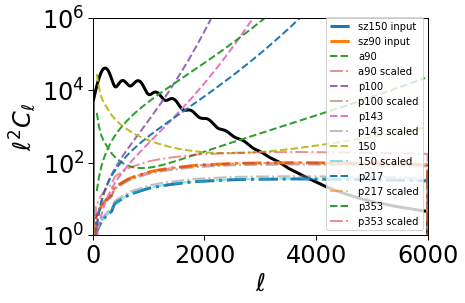

In [60]:
freqs = [90,100,143,149,217,353]
beams = [1.4*149./90.,9.66,7.27,1.4,5.01,4.86]
noises = [20.,65,43,10.,66,200]
lknees = [1000.,0,0,3000,0,0]
alphas = [-3.5,1,1,-3.5,1,1]
#lknees = [0.,0,0,0,0,0]
#alphas = [1,1,1,1,1,1]


def gnu(nu_ghz,tcmb=2.7255):
    nu = 1e9*nu_ghz
    hplanck = 6.62607e-34
    kboltzmann = 1.38065e-23 
    x = hplanck*nu/kboltzmann/tcmb
    coth = np.cosh(x/2.)/np.sinh(x/2.)
    return x*coth-4.

from szar import foregrounds as fgs
fnoises = fgs.fgNoises(cosmology.defaultConstants,ksz_file='../../szar/input/ksz_BBPS.txt',ksz_p_file='../../szar/input/ksz_p_BBPS.txt',tsz_cib_file='../../szar/input/sz_x_cib_template.dat',tsz_battaglia_template_csv="../../szar/input/sz_template_battaglia.csv",components=['tsz'],lmax=6000)

ps_sz_150 = fnoises.get_tot_fg_noise(150.,ells,components=['tsz'])
ps_sz_90 = fnoises.get_tot_fg_noise(90.,ells,components=['tsz'])


labels = ['a90','p100','p143','150','p217','p353']
bin_edges = np.arange(50,6000,40)
binner = stats.bin2D(modlmap,bin_edges)
marray = maps.MultiArray(shape,wcs)

marray.add_gaussian_foreground("tsz",ps_sz_150.reshape((1,1,ells.size)),150.,gnu)

marray.init_flat_cmb_sim(ps_cmb)
pl = io.Plotter(yscale='log',xlabel="$\\ell$",ylabel="$\\ell^2C_{\\ell}$")
pl.add(ells,ps_cmb[0,0]*ells**2.,lw=3,color='k')
pl.add(ells,ps_sz_150*ells**2.,lw=3,ls="-.",label="sz150 input")
pl.add(ells,ps_sz_90*ells**2.,lw=3,ls="-.",label="sz90 input")


for i,label in enumerate(labels):
    nT,nP = marray.add_array(label,freqs[i],beams[i],noises[i],lknee_T=lknees[i],alpha_T=alphas[i])
    cents,n1d = binner.bin(nT)
    pl.add(cents,n1d*cents**2.,lw=2,ls="--",label=label)
    pl.add(ells,ps_sz_150*ells**2.*((marray.freq_scale_func['tsz'](freqs[i])/(marray.freq_scale_func['tsz'](150.)))**2.),lw=2,alpha=0.5,ls="-.",label=label+" scaled")
pl._ax.set_xlim(0,6000)
pl._ax.set_ylim(1,1e6)
pl.legend(loc='lower right')
pl.done()
    



In [46]:
# Set up SZ frequency dependence


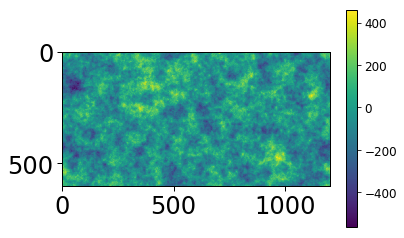

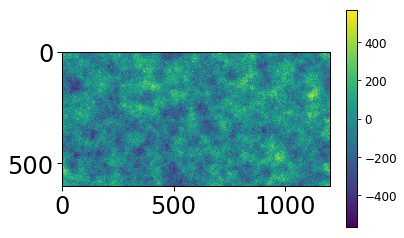

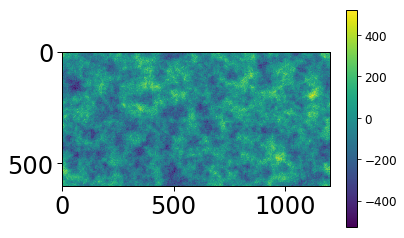

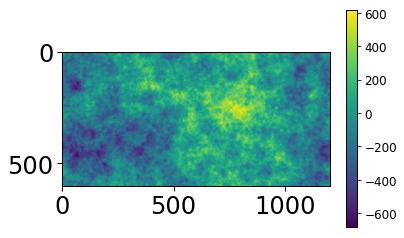

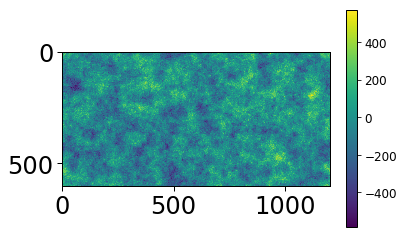

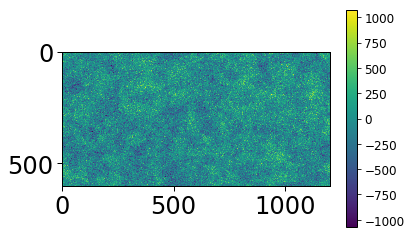

In [62]:


N = 10



for i in range(N):
    sky = marray.get_sky()
    if i==0:
        for j in range(sky.shape[0]):
            io.plot_img(sky[j])